# Time Series Analysis: MARA
In this notebook, we will perform a time series analysis on the historical stock price for MARA denoting Marathon Digital Holdings, Inc. The company operates as a digital asset technology company that mines cryptocurrencies with a focus on the blockchain ecosystem and the generation of digital assets in United States. As of December 31, 2021, it had approximately 8,115 bitcoins, which included the 4,794 bitcoins held in the investment fund.

## Table of Contents
1. Environment set-up
2. Initial Diagonistics
    * Basic Visualization
3. Decomposition
    * Detrend
    * Deseasonalize a Time Series
    * Test for seasonality of a Time Series
4. Stationary
    * How to make a time series stationary
    * How to test for stationarity
    * Difference between white noise and a stationary series
    * SARIMA
5. Autocorrelation
    * Autocorrelation and partial autocorrelation functions
    * Compute partial autocorrelation function
6. Lag Plots
7. Smoothening a Time Series
    * Exponential smoothing, Holt-Winters model
8. Granger Causality test
9. Machine Learning
    * Feature Engineering
        * Extraction
        * Importance
        * Selection
    * Linear models
    * Ensemble methods

# 1. Environment set-up

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
sns.set_theme()

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization
# Test for seasonality
from pandas.plotting import autocorrelation_plot

# Using scipy: Subtract the line of best fit
from scipy import signal

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

from dateutil.parser import parse

# Model Performance metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 2. Initial Diagonistics
    * Basic Visualization
    * Pattern recognition
    * How to treat missing values in a Time Series

In [3]:
df = pd.read_csv('MARA_5y.csv')
df['Date'] = df['Date'].apply(lambda x: x.replace(' 00:00:00-04:00', ' 00:00:00'))
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2017-10-10 00:00:00+00:00,6.56,6.72,6.24,6.56,39931,0,0.0
1,2017-10-11 00:00:00+00:00,6.40,6.72,6.40,6.40,27156,0,0.0
2,2017-10-12 00:00:00+00:00,6.40,6.72,6.08,6.40,38538,0,0.0
3,2017-10-13 00:00:00+00:00,6.24,6.56,6.24,6.40,20156,0,0.0
4,2017-10-16 00:00:00+00:00,6.40,7.04,6.40,6.56,46875,0,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   Date          1259 non-null   datetime64[ns, UTC]
 1   Open          1259 non-null   float64            
 2   High          1259 non-null   float64            
 3   Low           1259 non-null   float64            
 4   Close         1259 non-null   float64            
 5   Volume        1259 non-null   int64              
 6   Dividends     1259 non-null   int64              
 7   Stock Splits  1259 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(5), int64(2)
memory usage: 78.8 KB


In [5]:
# Close price is the actual final daily price -- renaming the column accordingly
df.rename({'Close':'Price'}, axis='columns', inplace=True)
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.head()

,Date,Open,High,Low,Price,Volume,Dividends,Stock Splits,Year,Month,Day
0,2017-10-10 00:00:00+00:00,6.56,6.72,6.24,6.56,39931,0,0.0,2017,10,10
1,2017-10-11 00:00:00+00:00,6.40,6.72,6.40,6.40,27156,0,0.0,2017,10,11
2,2017-10-12 00:00:00+00:00,6.40,6.72,6.08,6.40,38538,0,0.0,2017,10,12
3,2017-10-13 00:00:00+00:00,6.24,6.56,6.24,6.40,20156,0,0.0,2017,10,13
4,2017-10-16 00:00:00+00:00,6.40,7.04,6.40,6.56,46875,0,0.0,2017,10,16


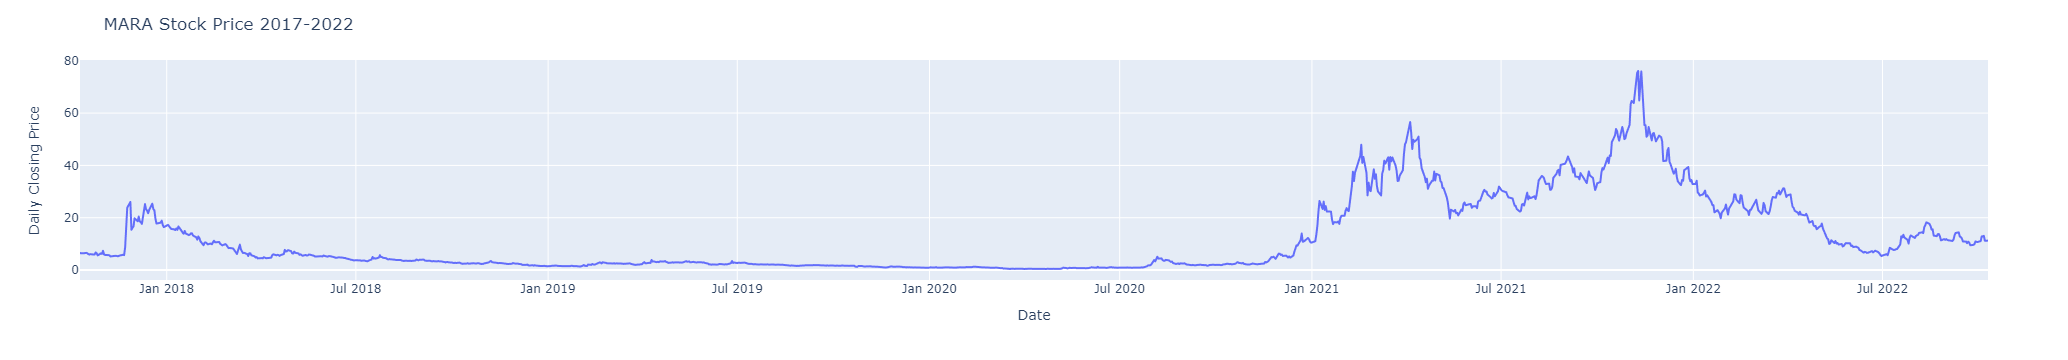

In [57]:
def plot_all(data=df, tck='MARA'):
    ''' Basic visual of a line plot of daily stock price overtime
    '''
    fig = px.line(df, x="Date", y="Price")
    fig.update_layout(title=tck+' Stock Price 2017-2022',
                       xaxis_title='Date',
                       yaxis_title='Daily Closing Price')
    fig.show()
plot_all()

# 3. Decomposition
For a continuous time series $F_{t}$ over a discrete-time period **t**, we can proceed in breaking down the series as an **addive function**: $F_{t}$ = $d_t$ + $s_t$ + $r_t$ or **multiplicative**: $F_{t}$ = $d_t$ * $s_t$ * $r_t$, where $d_{t}$ is a trend component, $s_{t}$ is a seasonal (periodic) component, and $r_{t}$ is a residual component. 

Given that those , the decomposition of a time series is the process by which we isolate all those single elements: trend, seasonality, and residual (after removing the trend and seasonality from the series). This technique serves to disentangle the time series for a more comprehensive analysis, most importantly facilitate the forecasting process.

* Detrend
* Deseasonalize a Time Series
* Test for seasonality of a Time Series

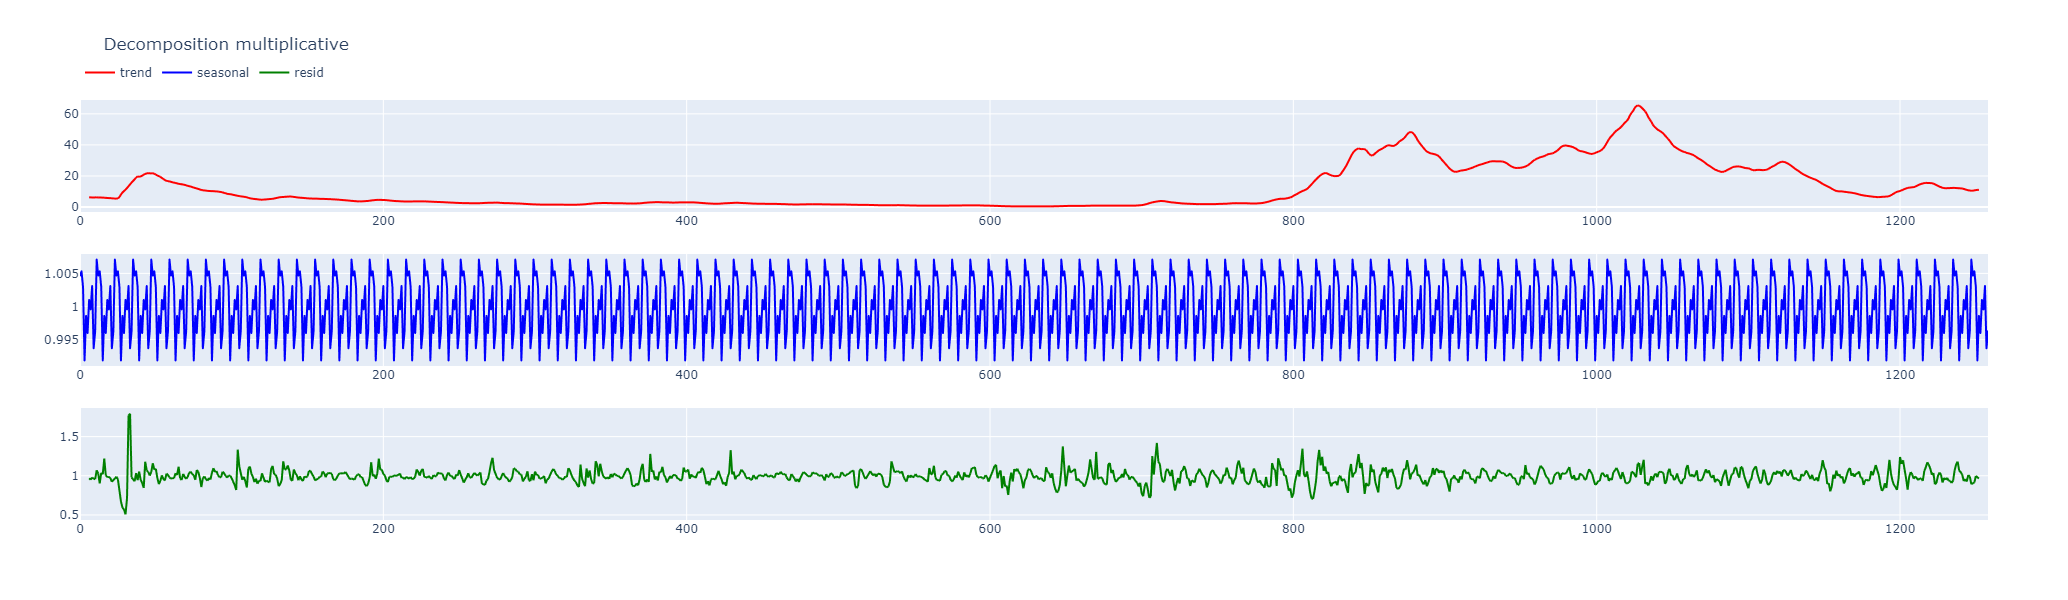

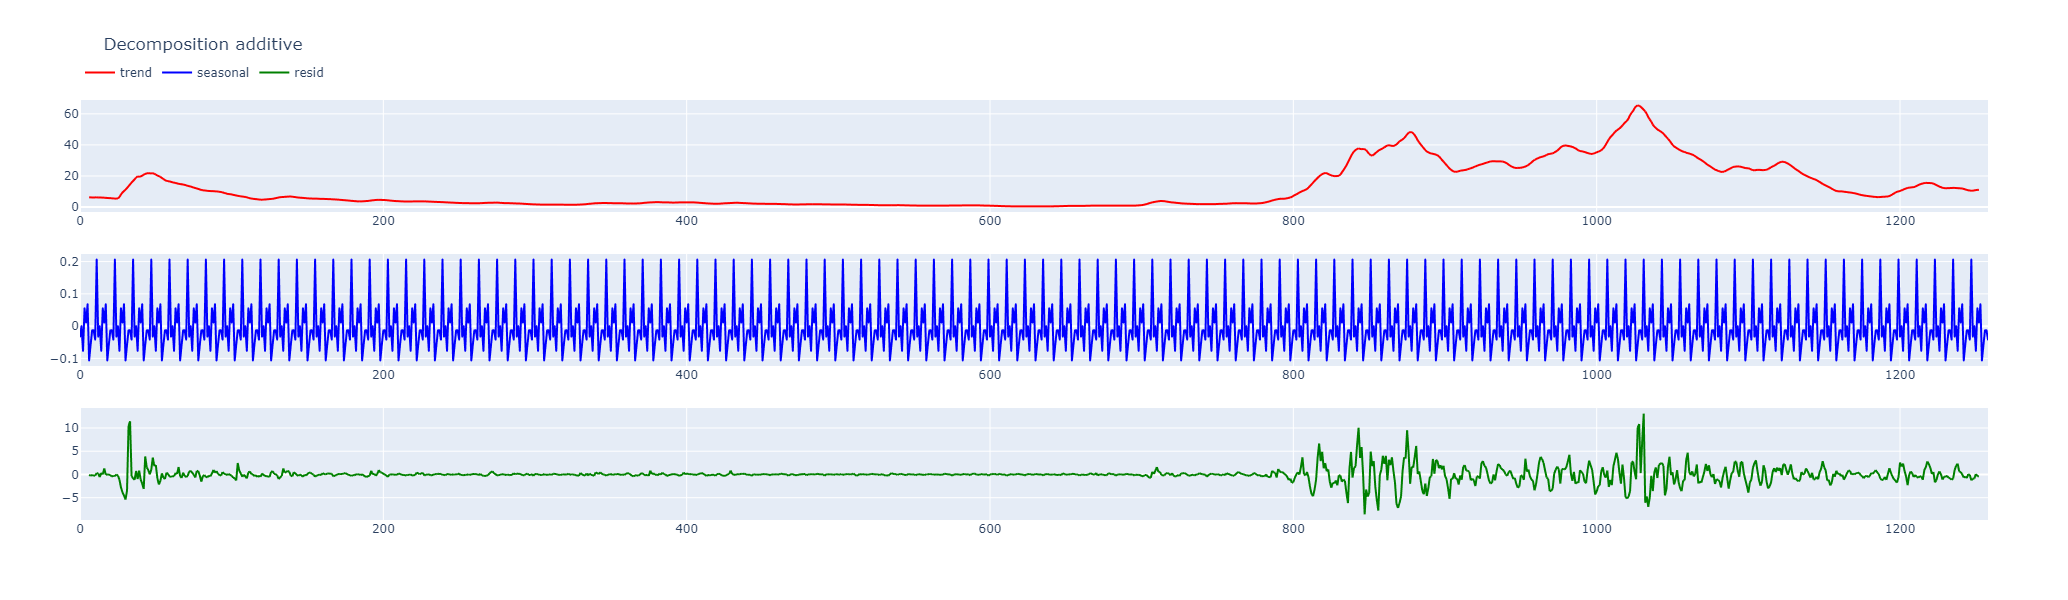

In [62]:
from plotly.subplots import make_subplots
def decomposition(data=df["Price"], prd=12, 
                  models = ['multiplicative','additive']):
    
    ''' Determine the suitable combination of base level, trend, seasonal index and the residual term.
    '''
    
    for mod in models:
        decomp_func = seasonal_decompose(data, model = mod, period=prd)
        #fig = make_subplots(rows=3, cols=1)
        figures = [
            px.line(decomp_func.trend, color_discrete_map={'trend':'red'}), 
            px.line(decomp_func.seasonal, color_discrete_map={'seasonal':'blue'}),
            px.line(decomp_func.resid, color_discrete_map={'resid':'green'})
        ]
        components = ['Trend', 'Seasonality','Error']
        fig = make_subplots(rows=len(figures), cols=1) 

        for i, figure in enumerate(figures):
            for trace in range(len(figure["data"])):
                fig.append_trace(figure["data"][trace], row=i+1, col=1)

        fig.update_layout(title="Decomposition "+mod, 
                          height=600,
                         legend=dict(orientation="h",
                                     yanchor="top", y=1.1,
                                     xanchor="left", x=0, )
                         )
        fig.show()

decomposition()